In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1
from sklearn.metrics import roc_auc_score

from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_validate, cross_val_score

from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier # wir benutzen den Random Forest Classifier von Sklearn
from sklearn.metrics import roc_curve

import optuna

---
Untenstehende Codezeilte dient nur zum Einlesen von den lokal abgespeicherten X_train, X_test, y_train, y_test Daten.

In [3]:
X_train = pd.read_csv("/Users/elocher/Computer_Science/FCS_Group/Data_for_modeling/X_train.csv")
X_test = pd.read_csv("/Users/elocher/Computer_Science/FCS_Group/Data_for_modeling/X_test.csv")
y_train = pd.read_csv("/Users/elocher/Computer_Science/FCS_Group/Data_for_modeling/y_train.csv")
y_test = pd.read_csv("/Users/elocher/Computer_Science/FCS_Group/Data_for_modeling/y_test.csv")

---

In [3]:
X_train = pd.read_csv("../data/training/X_train.csv")
X_test = pd.read_csv("../data/training/X_test.csv")
y_train = pd.read_csv("../data/training/y_train.csv")
y_test = pd.read_csv("../data/training/y_test.csv")

In [5]:
y_test['AccidentSeverityCategory'].value_counts()

AccidentSeverityCategory
0    8607
1    2909
Name: count, dtype: int64

`Class 0` represents accidents with property damage, while `class 1` stands for accidents with personal injuries (includes accident with minor injuries, accident with serious injuries and accident with fatalities). 

As we have to deal with imbalanced classes it makes more sense to create a binary classification problem.

In [6]:
# transform y_train and y_test to 1D array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [7]:
y_train

array([0, 0, 1, ..., 0, 0, 0])

In [29]:
# Zeige Spalten mit NaN-Werten und die Anzahl der NaN-Werte in diesen Spalten
nan_columns = X_train.isna().sum()
nan_columns = nan_columns[nan_columns > 0]
print(nan_columns)

traffic_volume_0_period_0          1
traffic_volume_1_period_0          1
traffic_volume_2_period_0          1
traffic_volume_0_period_1          3
traffic_volume_1_period_1          3
traffic_volume_2_period_1          3
pedestrian_volume_0_period_0    4065
pedestrian_volume_1_period_0    4065
pedestrian_volume_2_period_0    4065
pedestrian_volume_0_period_1    4066
pedestrian_volume_1_period_1    4066
pedestrian_volume_2_period_1    4066
dtype: int64


In [53]:
pd.DataFrame(X_train.columns)

,0
0,traffic_volume_0_period_0
1,traffic_volume_1_period_0
2,traffic_volume_2_period_0
3,traffic_volume_0_period_1
4,traffic_volume_1_period_1
...,...
94,hour_19
95,hour_20
96,hour_21
97,hour_22


In [ ]:
X_train[X_train['pedestrian_volume_0_period_0'].isna()]

,traffic_volume_0_period_0,traffic_volume_1_period_0,traffic_volume_2_period_0,traffic_volume_0_period_1,traffic_volume_1_period_1,traffic_volume_2_period_1,pedestrian_volume_0_period_0,pedestrian_volume_1_period_0,pedestrian_volume_2_period_0,pedestrian_volume_0_period_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
2,1.356202,1.177116,-0.973406,-0.521198,-0.647542,-1.170323,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.659556,0.060830,0.010740,-1.016124,-0.798663,-0.902099,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.270029,-0.146795,-0.662623,0.496012,0.066630,-0.517816,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
59,-1.039841,-0.979735,-0.727369,-1.033533,-0.966847,-0.827306,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
63,0.260087,0.031518,0.629716,0.242331,-0.267300,0.408073,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45968,-0.612331,-0.420370,0.044408,-0.364513,-0.013806,0.377125,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45994,-0.440830,-0.559601,-0.711830,-0.364513,-0.676791,-0.814410,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46017,-0.624759,-0.510748,-0.864632,-0.653012,-0.369673,-0.935627,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46041,-0.324010,-0.420370,-1.097719,-0.357052,-0.269738,-1.111004,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Creating some functions to calculate the result of our models and to visualize them

In [190]:
# We are going to create many models, let us keep track of their performance on cross-validation
# We will use a dataframe to store the results of the different models
results = pd.DataFrame({"Model": [], "Train_CV": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []})

In [8]:
# We create a scorer that computes the given scores (accuracy, precision, recall and f1-score) 
def make_scorefunc(loss_func, greater_is_better=True):
    def scorer(y, y_pred):
        return loss_func(y, y_pred)
    return make_scorer(scorer, greater_is_better=greater_is_better)

In [9]:
# Create the scorer dictionaries for the cross_val_score function
scorer = {
    "Accuracy": make_scorefunc(accuracy),
    "Precision": make_scorefunc(precision),
    "Recall": make_scorefunc(recall),
    "F1-Score": make_scorefunc(f1)
}

In [10]:
def compute_metrics(model, X_train, y_train, X_test, y_test, scorer, model_name=None):
    # Extract the names from the scorer dictionary
    scorer_names = list(scorer.keys())

    # Fit the model to the training set
    model.fit(X_train, y_train)
    
    ### Visualization: Confusion Matrix and ROC Curve ###
    # Predict probabilities (for ROC curve)
    y_probs = model.predict_proba(X_test)[:, 1]

    # Predict labels (for confusion matrix)
    y_pred = model.predict(X_test)

    # Create a dictionary for the pandas dataframe
    test_scores = {"Model": model_name, "Train_CV": "Test"}
    
    # Iterate over the scorers, now using y_test and y_pred
    for k in scorer_names:
        test_scores[k] = scorer[k](model, X_test, y_test)  # Pass y_test and y_pred to the scorer

    test_scores = pd.DataFrame(test_scores, index=[0])

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax1, cmap='Blues', colorbar=False)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    ax1.grid(False)

    # Calculate percentages for the confusion matrix
    cm_percent = cm / cm.sum() * 100  # Divide each cell by the total sum of the matrix to get percentages

    # Annotate with percentages below the numbers
    for i in range(cm.shape[0]):  # Iterate over rows
        for j in range(cm.shape[1]):  # Iterate over columns
            percentage = f"{cm_percent[i, j]:.1f}%"  # Format percentage
            ax1.text(j, i + 0.3, percentage, ha="center", va="center", fontsize=10, color="black")  # Add below numbers

    # Plot ROC curve
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc='lower right')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

    return test_scores

# First Model with simple Features

In [194]:
# Initialize the logistic regression model
log_reg = LogisticRegression(solver='liblinear')  # 'liblinear' is good for small datasets

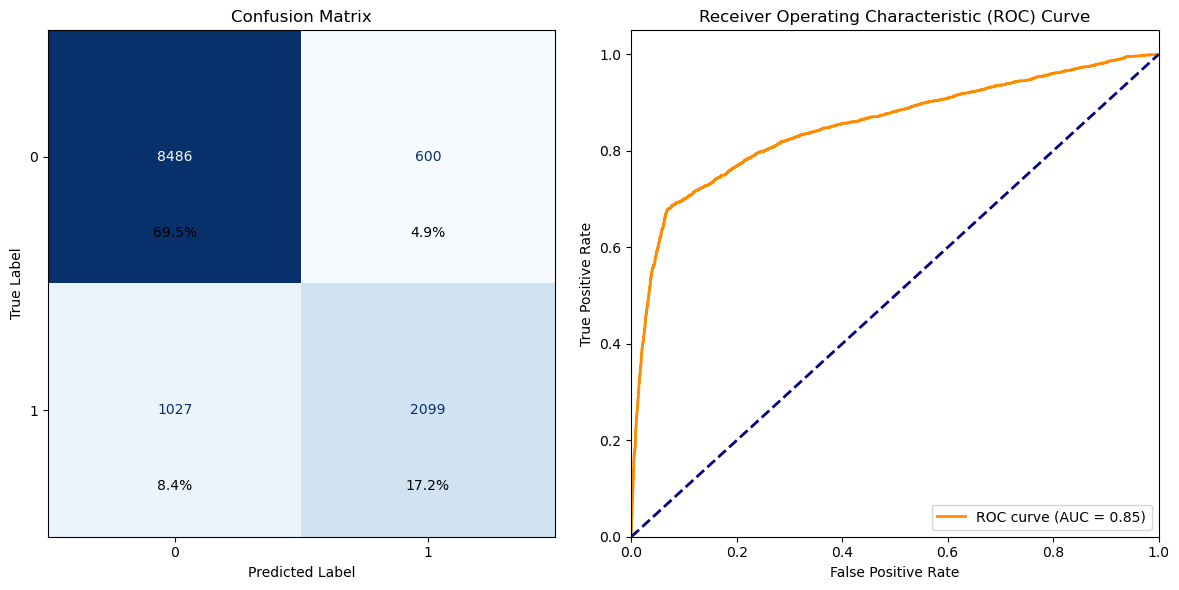

,Model,Train_CV,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,Test,0.86677,0.777695,0.671465,0.720687


In [195]:
compute_metrics(log_reg, X_train, y_train, X_test, y_test, scorer=scorer, model_name="Logistic Regression")

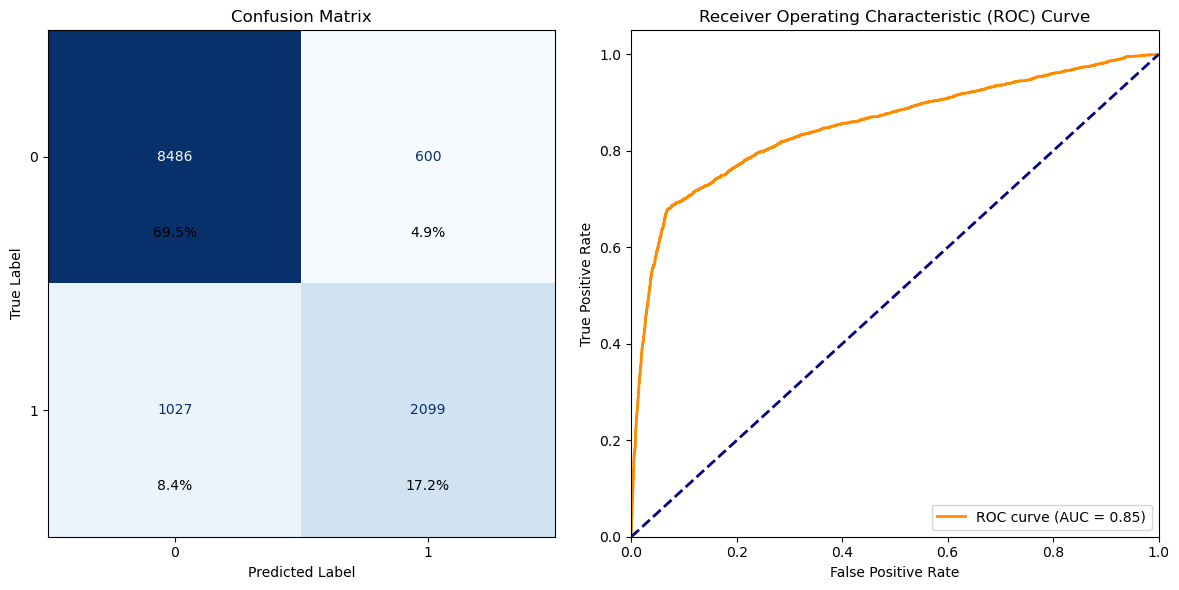

In [196]:
results = pd.concat([results, compute_metrics(log_reg, X_train, y_train, X_test, y_test, scorer=scorer, model_name="Logistic Regression")], axis=0)

In [197]:
results

,Model,Train_CV,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,Test,0.86677,0.777695,0.671465,0.720687


# Second Model with more Features

In [12]:
# Initialize the logistic regression model
log_reg2 = LogisticRegression(solver='liblinear')  # 'liblinear' is good for small datasets

In [13]:
log_reg_scores2 = compute_metrics(log_reg2, X_train, y_train, X_test, y_test, scorer=scorer, model_name="Logistic Regression")

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# RandomForest

We want to use a more systematic approach in finding the optimal hyperparameters of the Random Forest (RF). Therefore we will start with a RandomizedSearchCV. Once we have found the ‘best’ hyperparameters, we want to define a slightly narrower interval around these hyperparameters and then try to increase the performance of the model using BayesSearchCV.

### 1. Hyperparameters for RandomForest:

For the RandomForestClassifier, there are the following hyperparameters that we want to focus on:

#### Hyperparameters for the tree structure:

1. `max_depth` = The maximum depth of the individual trees.

The greater the depth of the trees, the more complex the structures/patterns can become. A high depth can result in overfitting, as the trees adapt too closely to the training data. Conversely, a smaller value reduces the model complexity.

---

2. `min_samples_split` = The minimum number of samples required to split a node.

A higher value leads to fewer trees, which can reduce overfitting.

---

3. `min_samples_leaf` = Minimum number of samples that a leaf node must have.

A higher value leads to "smoother" decision boundaries, thus reducing overfitting.

---

4. `max_features` = The maximum number of features considered when searching for the best split.

---

#### Hyperparameters that influence the number of trees in the forest:

5. `n_estimators` = Number of trees in the forest.

Higher values (i.e., number of trees) often improve performance but also increase training time.

---

6. `bootstrap` = Can be set to "True" or not. If set to "True", bootstrapping (sampling with replacement) is used when creating the trees.

---

#### Hyperparameters that influence the quality of the splits:

7. `class_weight` = Weighting of the classes in unbalanced datasets. This is particularly important for us as we are dealing with an unbalanced dataset.

---

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Definieren eines erweiterten Parameterbereichs für RandomizedSearchCV
param_dist = {
    'n_estimators': randint(400, 1000),  # Zufällige Werte zwischen 400 und 1000
    'max_depth': [None] + list(range(5, 30, 5)),  # None oder Werte von 5 bis 25 in 5er-Schritten
    'min_samples_split': randint(2, 10),  # Werte von 2 bis 10
    'min_samples_leaf': randint(1, 10),  # Werte von 1 bis 10
    'max_features': ['sqrt', 'log2', uniform(0.1, 0.9)],  # sqrt, log2, oder ein Bruchteil (0.1 bis 1.0)
    'bootstrap': [True, False],  # True oder False
    'class_weight': [None, 'balanced', 'balanced_subsample']  # Drei Optionen
}

# Basismodell definieren
forest_rs = RandomForestClassifier(random_state=74)

# RandomizedSearchCV einrichten
random_search = RandomizedSearchCV(estimator=forest_rs,
                                   param_distributions=param_dist,
                                   n_iter=100,  # Anzahl der zufälligen Konfigurationen, die getestet werden
                                   cv=cv,  # StratifiedKFold wie zuvor
                                   scoring='roc_auc',  # ROC-AUC als Metrik
                                   n_jobs=-1,  # Alle verfügbaren Kerne nutzen
                                   random_state=74,  # Reproduzierbarkeit
                                   verbose=2)  # Fortschrittsanzeige

# RandomizedSearchCV auf den Trainingsdatensatz fitten
random_search.fit(X_train, y_train)

# Beste Parameter ausgeben
print("Beste Parameter aus RandomizedSearchCV:", random_search.best_params_)

# Bestes Modell
best_model = random_search.best_estimator_


## Optional: Try out Optuna Software to find optimal Hyperparameters

In [ ]:
# Funktion zur Optimierung
def objective(trial):
    # Definieren des Hyperparameterbereichs
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])

    # Random Forest Modell mit den vorgeschlagenen Hyperparametern
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight=class_weight,
        random_state=74
    )
    
    # StratifiedKFold für die Kreuzvalidierung
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=74)

    # ROC-AUC als Bewertungsmethode
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    # Mittelwert der ROC-AUC über die Folds zurückgeben
    return scores.mean()

# Erstellen eines Optuna-Studiums
study = optuna.create_study(direction='maximize')  # Wir wollen die ROC-AUC maximieren
study.optimize(objective, n_trials=100)  # 100 Versuche für die Optimierung

# Beste Hyperparameter ausgeben
print("Beste Hyperparameter:", study.best_params)

# Bestes Modell trainieren
best_params = study.best_params
best_model = RandomForestClassifier(
    **best_params,
    random_state=74
)
best_model.fit(X_train, y_train)

# Testset-Bewertung
from sklearn.metrics import roc_auc_score
y_probs = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC auf Testdaten: {roc_auc:.4f}")